In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
import pandas as pd
import utils_v2 as utils

### Reading processed word embeddings

In [0]:
word_embeddings_matrix = utils.open_pickle(filename="generated_data/reddit_words_embeddings")

In [10]:
word_embeddings_matrix.shape

(31674, 300)

### Reading processed news sequences

In [0]:
news_sequences = utils.open_pickle(filename="generated_data/reddit_news_sequences") 

In [12]:
news_sequences.head()

,Date,news_sequence
0,2008-09-19,"[0, 1, 2, 3, 4, 5, 6, 31672, 7, 8, 9, 10, 11, ..."
1,2008-09-22,"[159, 160, 161, 162, 163, 164, 165, 166, 167, ..."
2,2008-09-23,"[329, 259, 330, 331, 332, 124, 31672, 333, 334..."
3,2008-09-24,"[458, 281, 459, 460, 461, 462, 31672, 218, 463..."
4,2008-09-25,"[585, 586, 587, 291, 588, 589, 590, 591, 592, ..."


### Loading stock sequences and stock labels

In [0]:
stock_sequences = utils.open_pickle(filename="generated_data/GOOG_reddit_stock_sequences")
stock_labels = utils.open_pickle(filename="generated_data/GOOG_reddit_stock_labels")

In [14]:
stock_sequences.shape

(1959, 30, 81)

In [15]:
stock_labels.shape

(1959,)

### Creating training and test data

In [0]:
indexes = [i for i in range(len(news_sequences))]
np.random.seed(1)
np.random.shuffle(indexes)
train_size = int(.75*len(indexes))

seq_train = np.array(list(news_sequences.iloc[indexes[:train_size]]['news_sequence'].values))
stock_train = np.array(stock_sequences[indexes[:train_size]])
y_train = np.array(stock_labels[indexes[:train_size]])

seq_test = np.array(list(news_sequences.iloc[indexes[train_size:]]['news_sequence'].values))
stock_test = np.array(stock_sequences[indexes[train_size:]])
y_test = np.array(stock_labels[indexes[train_size:]])

In [17]:
seq_train.shape, stock_train.shape, y_train.shape, seq_test.shape, stock_test.shape, y_test.shape

((1469, 308), (1469, 30, 81), (1469,), (490, 308), (490, 30, 81), (490,))

In [18]:
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Conv1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model, load_model # Functional Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Word embeddings provide a dense representation of words and their relative meanings. A word embedding is a class of approaches for representing words and documents using a dense vector representation.It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.

In [39]:
input1 = Input(shape=(seq_train.shape[1],), dtype='int32', name="input1")

"""
input_dim: This is the size of the vocabulary in the text data. 
For example, if your data is integer encoded to values between 0-10, 
then the size of the vocabulary would be 11 words.

output_dim: This is the size of the vector space in which words will be embedded. 
It defines the size of the output vectors from this layer for each word. 
For example, it could be 32 or 100 or even larger. Test different values for your problem.

input_length: This is the length of input sequences, 
as you would define for any input layer of a Keras model. 
For example, if all of your input documents are comprised of 1000 words, this would be 1000.

weights: pre-trained word embeddings
"""
x1 = Embedding(input_length=seq_train.shape[1],
               input_dim=word_embeddings_matrix.shape[0], 
                output_dim=word_embeddings_matrix.shape[1],
                weights=[word_embeddings_matrix])(input1)


Conv1D1 = Conv1D(filters = 3, 
                 kernel_size = 4, 
                 padding = 'same',
                 activation = 'relu')(x1)
dropout1 = Dropout(0.25)(Conv1D1)

weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)

lstm_out1 = LSTM(units=128, 
               activation=None,
               kernel_initializer=weights,
               dropout = .2)(dropout1)

auxiliary_output1 = Dense(3, activation='softmax', name='aux_output1')(lstm_out1)
#############

input2 = Input(shape=(stock_train.shape[1], stock_train.shape[2]), name="input2")

weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=4)

lstm2 = LSTM(units=256, 
               activation=None,
               kernel_initializer=weights,
               dropout = .2,
             return_sequences = True)(input2)


# x2 = Embedding(input_length=X_train.shape[1],
#                input_dim=word_embeddings_matrix.shape[0], 
#                 output_dim=word_embeddings_matrix.shape[1],
#                 weights=[word_embeddings_matrix])(input2)

# Conv1D2 = Conv1D(filters = 3, 
#                  kernel_size = 4, 
#                  padding = 'same',
#                  activation = 'relu')(x2)
# dropout2 = Dropout(0.25)(Conv1D2)

weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=5)

lstm_out2 = LSTM(units=128, 
               activation=None,
               kernel_initializer=weights,
               dropout = .2)(lstm2)

auxiliary_output2 = Dense(3, activation='softmax', name='aux_output2')(lstm_out2)

x = concatenate([lstm_out1, lstm_out2])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(3, activation='softmax', name='main_output')(x)

# model with two inputs and two outputs:
model = Model(inputs=[input1, input2], outputs=[auxiliary_output1, auxiliary_output2, main_output])
optimizer = Adam(lr=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


reduceLR = ReduceLROnPlateau(monitor='val_main_output_loss', factor=0.1, patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('NewsStockSeqModel.h5', monitor='val_main_output_acc', mode='auto', verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_main_output_acc', min_delta=0, patience=5, verbose=1)

# model.compile(optimizer=optimizer,
#               loss={'main_output': 'categorical_crossentropy', 
#                     'aux_output1': 'categorical_crossentropy',
#                     'aux_output2': 'categorical_crossentropy'}, metrics=['accuracy'])

# # And trained it via:
# model.fit({'main_input': headline_data, 'aux_input': additional_data},
#           {'main_output': headline_labels, 'aux_output': additional_labels},
#           epochs=50, batch_size=32)
print("-----------Fitting Model------------------->")
model.fit([seq_train, stock_train], [y_train, y_train, y_train], validation_split=0.1,
          batch_size=64, epochs=10, callbacks=[earlyStopping, checkpoint, reduceLR])

-----------Fitting Model------------------->
Train on 1322 samples, validate on 147 samples
Epoch 1/10
1322/1322 [==============================] - 27s 21ms/step - loss: 3.2675 - aux_output1_loss: 1.0866 - aux_output2_loss: 1.0971 - main_output_loss: 1.0839 - aux_output1_acc: 0.3729 - aux_output2_acc: 0.3933 - main_output_acc: 0.4077 - val_loss: 3.2031 - val_aux_output1_loss: 1.0782 - val_aux_output2_loss: 1.0642 - val_main_output_loss: 1.0607 - val_aux_output1_acc: 0.3946 - val_aux_output2_acc: 0.3537 - val_main_output_acc: 0.3810

Epoch 00001: val_main_output_acc improved from -inf to 0.38095, saving model to NewsStockSeqModel.h5
Epoch 2/10
1322/1322 [==============================] - 22s 17ms/step - loss: 3.2115 - aux_output1_loss: 1.0778 - aux_output2_loss: 1.0656 - main_output_loss: 1.0682 - aux_output1_acc: 0.4032 - aux_output2_acc: 0.4123 - main_output_acc: 0.4198 - val_loss: 3.1543 - val_aux_output1_loss: 1.0701 - val_aux_output2_loss: 1.0443 - val_main_output_loss: 1.0399 - va

In [40]:
# Evaluating using best Model
model = load_model('NewsStockSeqModel.h5')
print("-----------Evaluating Model---------------->")
## evaluating model ##
model.evaluate([seq_test, stock_test], [y_test, y_test, y_test])

-----------Evaluating Model---------------->
490/490 [==============================] - 8s 15ms/step


[3.2720933164869037,
 1.089860708859502,
 1.0932272312592486,
 1.089005303869442,
 0.3489795918367347,
 0.40408163265306124,
 0.38367346950939724]

In [41]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 308)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 308, 300)     9502200     input1[0][0]                     
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 308, 3)       3603        embedding_3[0][0]                
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 30, 81)       0                                            
____________________________________________________________________________________________

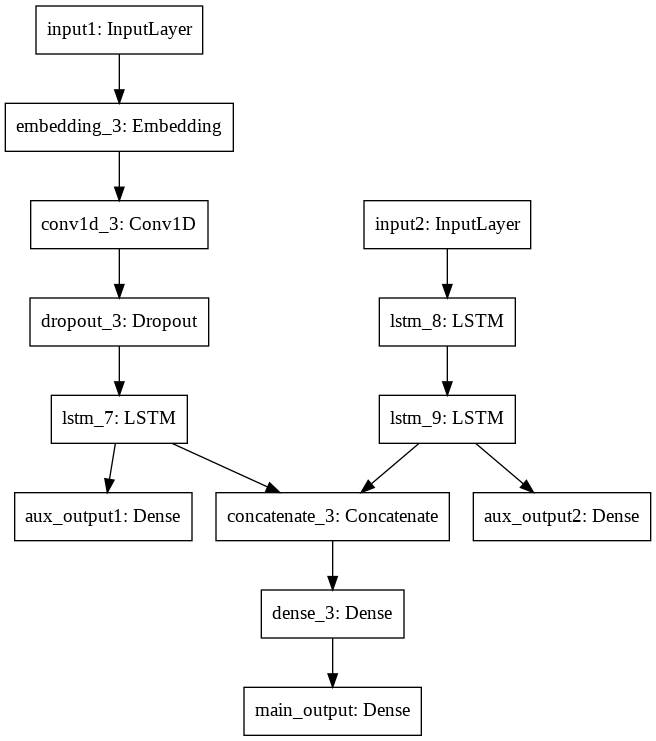

In [42]:
from keras.utils import plot_model
plot_model(model, to_file='reddit_combined_model.png')

In [0]:
y_pred_prob = model.predict([seq_train, stock_train])

seq_pred_prob = y_pred_prob[0]
stock_pred_prob = y_pred_prob[1]
combined_pred_prob = y_pred_prob[2]

seq_pred = np.array([np.argmax(y) for y in seq_pred_prob])
stock_pred = np.array([np.argmax(y) for y in stock_pred_prob])
combined_pred = np.array([np.argmax(y) for y in combined_pred_prob])

y_true = np.array([np.argmax(y) for y in y_train])

Accuracy: 0.396
Precision: 0.396
Recall: 0.396
F1 score: 0.396





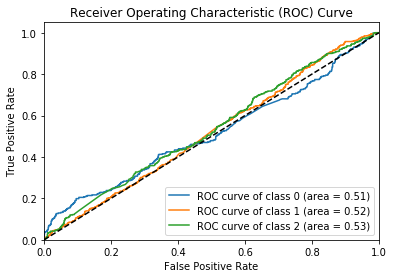

In [44]:
utils.print_metrics(y_true, seq_pred, seq_pred_prob, 'sequence_roc_train')

Accuracy: 0.460
Precision: 0.460
Recall: 0.460
F1 score: 0.460





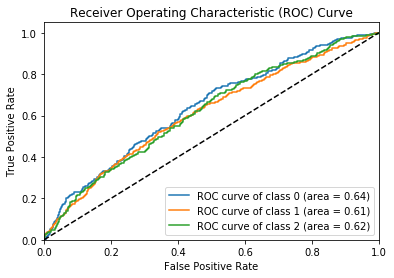

In [45]:
utils.print_metrics(y_true, stock_pred, stock_pred_prob, 'stock_roc_train')

Accuracy: 0.468
Precision: 0.468
Recall: 0.468
F1 score: 0.468





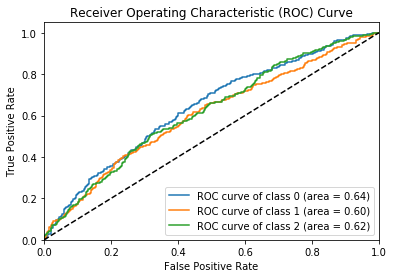

In [46]:
utils.print_metrics(y_true, combined_pred, combined_pred_prob, 'combined_roc_train')

In [0]:
y_pred_prob = model.predict([seq_test, stock_test])

seq_pred_prob = y_pred_prob[0]
stock_pred_prob = y_pred_prob[1]
combined_pred_prob = y_pred_prob[2]

seq_pred = np.array([np.argmax(y) for y in seq_pred_prob])
stock_pred = np.array([np.argmax(y) for y in stock_pred_prob])
combined_pred = np.array([np.argmax(y) for y in combined_pred_prob])

y_true = np.array([np.argmax(y) for y in y_test])

Accuracy: 0.349
Precision: 0.349
Recall: 0.349
F1 score: 0.349





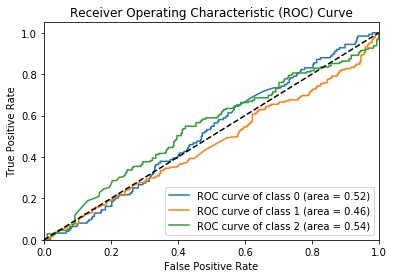

In [48]:
utils.print_metrics(y_true, seq_pred, seq_pred_prob, 'sequence_roc_test')

Accuracy: 0.404
Precision: 0.404
Recall: 0.404
F1 score: 0.404





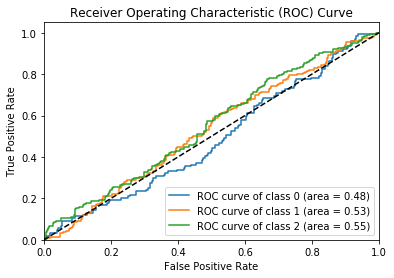

In [49]:
utils.print_metrics(y_true, stock_pred, stock_pred_prob, 'stock_roc_test')

Accuracy: 0.384
Precision: 0.384
Recall: 0.384
F1 score: 0.384





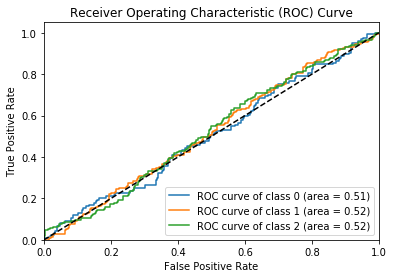

In [50]:
utils.print_metrics(y_true, combined_pred, combined_pred_prob, 'combined_roc_test')